In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from orbitize.results import Results

In [2]:
# load the posteriors from the various orbit fits

nograv_results = Results()
nograv_results.load_results('results/with_literature_astrom/chains.hdf5')

onegrav_results = Results()
onegrav_results.load_results('results/with_literature_astromwith_first_vlti_point/chains.hdf5')

twograv_results = Results()
twograv_results.load_results('results/with_literature_astromwith_first_vlti_pointwith_second_vlti_point/chains.hdf5')

onlygrav_results = Results()
onlygrav_results.load_results('results/with_first_vlti_pointwith_second_vlti_point/chains.hdf5')

all_results = [nograv_results, onegrav_results, twograv_results, onlygrav_results]

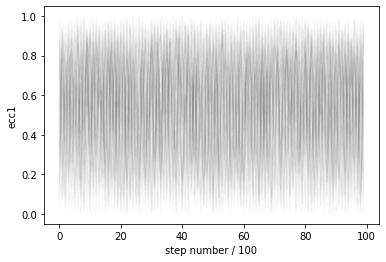

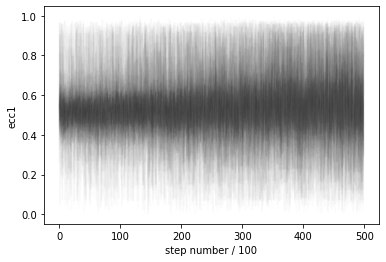

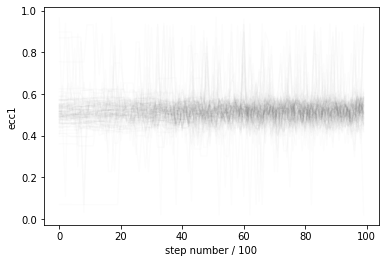

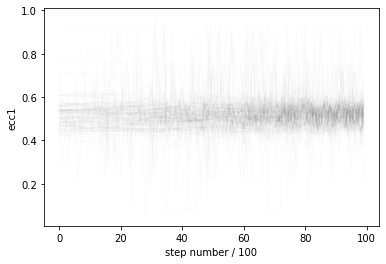

In [9]:
# make MCMC convergence plots

param = 'ecc1'

for res in all_results:
    smas = res.post[:, res.system.param_idx[param]]

    num_walkers = 1000
    n_steps = len(smas) // num_walkers
    chn = smas.reshape((num_walkers, n_steps))

    walkers_to_plot = np.random.choice(num_walkers, size=100, replace=False)
    plt.figure()
    for w in walkers_to_plot:
        plt.plot(chn[w, :], color='k', alpha=0.01)
    plt.xlabel('step number / 100')
    plt.ylabel(param)


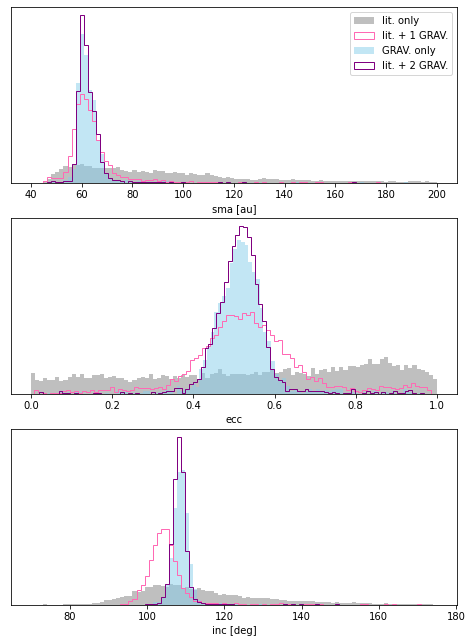

In [118]:
# plot all the sma, ecc, and inc posteriors
fig, ax = plt.subplots(3, 1, figsize=(8,11))
for a in ax:
    a.set_yticks([])

ax[0].set_xlabel('sma [au]')
ax[1].set_xlabel('ecc')
ax[2].set_xlabel('inc [deg]')

plot_dict = {
    nograv_results: {'ec': None, 'fc': 'grey', 'alpha': 0.5, 'histtype':'stepfilled'},
    onegrav_results: {'ec': 'hotpink', 'fc': 'white', 'histtype':'step'},
    twograv_results: {'ec': 'purple', 'fc': 'white',  'histtype':'step'},
    onlygrav_results: {'ec': None, 'fc': 'skyblue',  'histtype':'stepfilled', 'alpha':0.5}
}

for res, lab in zip(
    [nograv_results, onegrav_results, onlygrav_results, twograv_results],
    ['lit. only', 'lit. + 1 GRAV.', 'GRAV. only', 'lit. + 2 GRAV.']
):
    ax[0].hist(res.post[:, res.system.param_idx['sma1']], bins=100, range=(40, 200), label=lab, **plot_dict[res])
    ax[1].hist(res.post[:, res.system.param_idx['ecc1']], bins=100, **plot_dict[res])
    ax[2].hist(np.degrees(res.post[:, res.system.param_idx['inc1']]), range=(70, 175), bins=100, **plot_dict[res])

ax[0].legend()
plt.savefig('results/plots/orbit_compare.png', dpi=250)

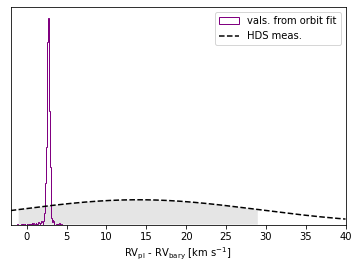

In [119]:
# plot the planetary RV vs the measurement

rv_epoch = twograv_results.data[twograv_results.data['quant_type'] == 'rv']['epoch'].value[0]

# compute the planetary RV at the measured epoch for each posterior sample
_, _, rv_out = twograv_results.system.compute_all_orbits(
    twograv_results.post.T, epochs=np.array([rv_epoch])
)

rv_predictions = rv_out[0,1,:]
plt.figure()
plt.hist(
    rv_predictions, bins=100, density=True, label='vals. from orbit fit', 
    histtype='step', color='purple'
)

# overplot the RV measurement and uncertainty
rv_meas = twograv_results.data[twograv_results.data['quant_type'] == 'rv']['quant1'].value[0]
rv_unc = twograv_results.data[twograv_results.data['quant_type'] == 'rv']['quant1_err'].value[0]

rv2plot = np.linspace(-2, 40, int(1e3))

def norm(x, mu, sig):
    return 1 / (sig * np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x - mu)/sig)**2)

plt.plot(rv2plot, 10 * norm(rv2plot, rv_meas, rv_unc), label='HDS meas.', color='k', ls='--')
plt.yticks([])
plt.xlabel('RV$_{{\\rm pl}}$ - RV$_{{\\rm bary}}$ [km s$^{{-1}}$]')
plt.xlim(-2,40)

onesig_rvrange = np.linspace(rv_meas - rv_unc, rv_meas + rv_unc, int(1e3))
plt.fill_between(
    onesig_rvrange, np.zeros(int(1e3)), 10 * norm(onesig_rvrange, rv_meas, rv_unc),
    color='k', alpha=0.1, ec=None
)

plt.legend()
plt.savefig('results/plots/rv_meas.png', dpi=250)

In [12]:
# make orbit plot

fig = GridSpec(2, 3)

fig = twograv_results.plot_orbits(num_epochs_to_plot=500, start_mjd=56000, fig=fig)
plt.savefig('results/plots/orbit_fancy.png', dpi=250)

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_current_figure'